In [1]:
import tensorflow
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.merge import concatenate
from keras import backend as K

Using TensorFlow backend.


In [2]:
import gzip
import os
from scripts.deepgtav.messages import frame2numpy

filepath = os.path.join(os.getcwd(), 'data')
filename = "dataset_small.pz"
pfile = gzip.open(os.path.join(filepath, filename), mode='rb')

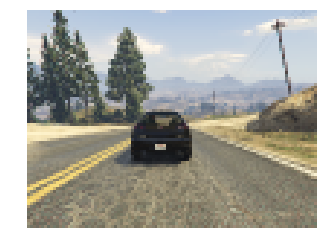

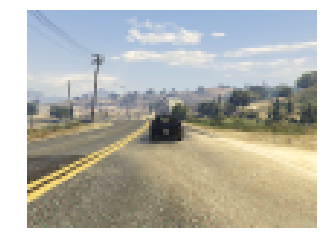

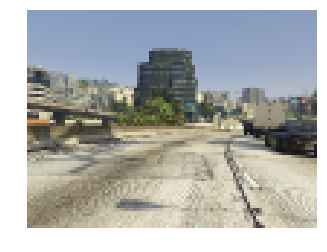

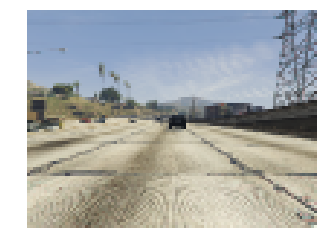

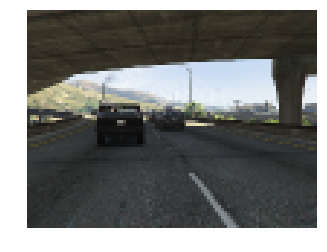

In [3]:
import pickle
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

count = 0
no_of_channels = 3

frames_per_weather = 20000
reps_per_weather = 8
frames_per_rep = int(frames_per_weather/reps_per_weather)
image_size = (200,150)

x = []
y = []

while True:
    try:
        
        # Load var from pickle
        var = pickle.load(pfile)
        
        # Skip first n frames
        count += 1
        # if count<3000: continue
            
        # Save image and steering
        image = frame2numpy(var['frame'], image_size)
        image = cv2.resize(image, (100,75))
        x.append(image)
        # y.append([var['steering'], var['throttle'], var['brake']])
        y.append([var['steering']])
        
        # Display image
        if count % 1000 == 0:
            plt.imshow(image[:,:,::-1])
            plt.axis('off')
            plt.show()
        
        if count>5000: break
            
    except EOFError: break

In [4]:
import numpy as np

prev_keys = 60

# Convert to numpy
x = np.array(x)
x = (x/255 - 0.5) * 2
 
y = np.array(y)

x2 = np.zeros((x.shape[0], prev_keys))
gamma = 0.5

# Create previous key sets for each training data

for i in range(x2.shape[0]):
    count = 0
    for j in range(i, i-prev_keys, -1):
        x2[i][count] = y[j-prev_keys]*(j>0)*(gamma**(count))
        count += 1

print('Dataset Shape', x.shape, x2.shape, y.shape)

Dataset Shape (5001, 75, 100, 3) (5001, 60) (5001, 1)


In [5]:
x_final = [x[0,:,:,:], x2[0,:]]
for i in range(1, x.shape[0]):
    x_final = np.vstack((x_final, [x[i,:,:,:], x2[i,:]]))
print('Combined Dataset Shape', x_final.shape)

Combined Dataset Shape (5001, 2)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.2, random_state=np.random)
print("Train Data | Test Data")
print(("{0:^10} | {1:^10}").format(x_train.shape[0], x_test.shape[0]))

Train Data | Test Data
   4000    |    1001   


In [13]:
row = 75
column = 100
channels = 3

visible1 = Input(shape=(75,100,3))
conv1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(row,column,channels))(visible1)
conv2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool1)
conv4 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv3)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool2)
conv6 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv5)
conv7 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv6)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv7)
output1 = Flatten()(pool3)

visible2 = Input(shape=(prev_keys,))
output2 = Dense(40, activation='tanh')(visible2)

conc_inp = concatenate([output1, output2])
dense1 = Dense(4096, activation='tanh')(conc_inp)
dense2 = Dense(2048, activation='tanh')(dense1)
dense3 = Dense(1, activation='tanh')(dense2)

model = Model(inputs=[visible1, visible2], outputs=dense3)

In [14]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 73, 98, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 71, 96, 64)   36928       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 35, 48, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 

In [9]:
x1_train = np.array(x_train[0][0])
x2_train = np.array(x_train[0][1])
x1_test = np.array(x_test[0][0])
x2_test = np.array(x_test[0][1])
print(x_train.shape[0], x_test.shape[0])
print('Completed training data: ', end=' ')
for i in range(1, x_train.shape[0]):
    x1_train = np.vstack((x1_train, x_train[i][0]))
    x2_train = np.vstack((x2_train, x_train[i][1]))
    if i%100 == 0:
        print(i, end=', ')
print('Completed testing data: ', end=' ')
for i in range(1, x_test.shape[0]):
    x1_test = np.vstack((x1_test, x_test[i][0]))
    x2_test = np.vstack((x2_test, x_test[i][1]))
    if i%100 == 0:
        print(i, end=', ')


4000 1001
Completed training data:  100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, Completed testing data:  100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 

In [10]:
x1_train = np.reshape(x1_train, (x_train.shape[0],row,column,channels))
x2_train = np.reshape(x2_train, (x_train.shape[0], prev_keys))

x1_test = np.reshape(x1_test, (x_test.shape[0],row,column,channels))
x2_test = np.reshape(x2_test, (x_test.shape[0], prev_keys))

print('Combined Training Dataset Shape', x1_train.shape, x2_train.shape)
print('Combined Testing Dataset Shape', x1_test.shape, x2_test.shape)

Combined Training Dataset Shape (4000, 75, 100, 3) (4000, 60)
Combined Testing Dataset Shape (1001, 75, 100, 3) (1001, 60)


In [15]:
from keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=['mean_absolute_percentage_error'])

model.fit([x1_train, x2_train], y_train, validation_split=0.1, epochs=10, batch_size=5)

Train on 3600 samples, validate on 400 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[8232,4096]
	 [[Node: dense_6/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=3345712, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_6/random_uniform/shape)]]

Caused by op 'dense_6/random_uniform/RandomUniform', defined at:
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tornado\platform\asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\asyncio\base_events.py", line 1431, in _run_once
    handle._run()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tornado\platform\asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-06e8a1be2545>", line 22, in <module>
    dense1 = Dense(4096, activation='tanh')(conc_inp)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\keras\layers\core.py", line 842, in build
    constraint=self.kernel_constraint)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\topology.py", line 413, in add_weight
    weight = K.variable(initializer(shape),
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\keras\initializers.py", line 217, in __call__
    dtype=dtype, seed=self.seed)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py", line 3832, in random_uniform
    dtype=dtype, seed=seed)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 472, in _random_uniform
    name=name)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "c:\users\sambi\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[8232,4096]
	 [[Node: dense_6/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=3345712, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_6/random_uniform/shape)]]
